Code based on https://github.com/pytorch/examples/blob/master/mnist/main.py

In this exercise, we are going to implement a [UNet-like](https://arxiv.org/pdf/1505.04597.pdf) architecture for the semantic segmentation task.
The model is trained on the [Pascal VOC](https://paperswithcode.github.io/torchbench/pascalvoc/) dataset.

Tasks:

    1. Implement the missing pieces in the code.

    2. Check that the given implementation reaches 68% test accuracy after a few epochs.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode

In [2]:
class UNetConvolutionStack(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(UNetConvolutionStack, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

In [3]:
class EncoderStack(nn.Module):
    def __init__(self, in_channel, out_channel, first_layer=False):
        super(EncoderStack, self).__init__()
        if first_layer:
            self.down = nn.Sequential(
                UNetConvolutionStack(in_channel, out_channel),
                UNetConvolutionStack(out_channel, out_channel),
            )
        else:
            self.down = nn.Sequential(
                nn.MaxPool2d((2, 2)),
                UNetConvolutionStack(in_channel, out_channel),
                UNetConvolutionStack(out_channel, out_channel),
            )
    def forward(self, x):
        x = self.down(x)
        return x


In [20]:
class DecoderStack(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(DecoderStack, self).__init__()
        self.upsample = nn.ConvTranspose2d(
            in_channel, in_channel, 3, stride=2, padding=1
        )
        self.up = nn.Sequential(
            UNetConvolutionStack(in_channel + out_channel, out_channel),
            UNetConvolutionStack(out_channel, out_channel),
        )
        self.inc = in_channel+out_channel
        self.outc = out_channel

    def forward(self, x, y):
        # TODO: implement skipconnections.
        # hint: x is the output of previous decoder layer,
        # y is the output of corresponding encoder layer.
        # Based on the arguments of the constructor,
        # how should x and y be combined?
        z = torch.cat([torch.nn.functional.pad(self.upsample(x), (1, 0, 1, 0)), y], dim=1)
        # print(self.inc, self.outc)
        # print(z.size(), self.up(z).size())
        return self.up(z)

In [21]:
class UNet(nn.Module):
    def __init__(self, encoder_channels, decoder_channels, num_classes):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.conv = nn.Conv2d(
            decoder_channels[-1], num_classes, kernel_size=3, padding=1
        )

        encoder_sizes = zip(
            range(len(encoder_channels)), encoder_channels, encoder_channels[1:]
        )
        for idx, in_size, out_size in encoder_sizes:
            if idx > 0:
                self.encoder.append(EncoderStack(in_size, out_size))
            else:
                self.encoder.append(EncoderStack(in_size, out_size, first_layer=True))

        decoder_sizes = zip(decoder_channels, decoder_channels[1:])
        for in_size, out_size in decoder_sizes:
            self.decoder.append(DecoderStack(in_size, out_size))

    def forward(self, x):
        # TODO: implement UNet's forward pass.
        # hint: Remeber to store outputs of subsequent
        # encoder layers to use as input to decoer layers!
        # Do not forget about the final convolution.
        outputs = []
        for encoder in self.encoder[:-1]:
          x = encoder(x)
          outputs.append(x)
        x = self.encoder[-1](x)
        for decoder, y in zip(self.decoder, reversed(outputs)):
          # print(f"Before decoding: {x.size()}")
          x = decoder(x, y)
          # print(f"After decoding: {x.size()}\n")
        return self.conv(x)

In [6]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    _, _, image_width, image_height = data.size()
    test_loss /= len(test_loader.dataset) * image_width * image_height

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            (len(test_loader.dataset) * image_width * image_height),
            100.0 * correct / (len(test_loader.dataset) * image_width * image_height),
        )
    )

In [7]:
batch_size = 128
test_batch_size = 1000
epochs = 5
lr = 1e-2
use_cuda = True
seed = 1
log_interval = 10

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
num_classes = 22

In [8]:
use_cuda = use_cuda and torch.cuda.is_available()

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {"batch_size": batch_size}
test_kwargs = {"batch_size": test_batch_size}
if use_cuda:
    cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

In [9]:
def replace_tensor_value_(tensor, a, b):
    tensor[tensor == a] = b
    return tensor


input_resize = transforms.Resize((224, 224))
input_transform = transforms.Compose(
    [
        input_resize,
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

target_resize = transforms.Resize((224, 224), interpolation=InterpolationMode.NEAREST)
target_transform = transforms.Compose(
    [
        target_resize,
        transforms.PILToTensor(),
        transforms.Lambda(
            lambda x: replace_tensor_value_(x.squeeze(0).long(), 255, 21)
        ),
    ]
)

In [10]:
dataset1 = datasets.VOCSegmentation(
    "../data",
    year="2012",
    image_set="train",
    download=True,
    transform=input_transform,
    target_transform=target_transform,
)
dataset2 = datasets.VOCSegmentation(
    "../data",
    year="2012",
    image_set="val",
    download=True,
    transform=input_transform,
    target_transform=target_transform,
)

train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **train_kwargs)

100%|██████████| 1999639040/1999639040 [00:51<00:00, 38824689.08it/s]


Extracting ../data/VOCtrainval_11-May-2012.tar to ../data
Using downloaded and verified file: ../data/VOCtrainval_11-May-2012.tar
Extracting ../data/VOCtrainval_11-May-2012.tar to ../data


In [22]:
model = UNet(
    encoder_channels=[3, 8, 16, 32],
    decoder_channels=[32, 16, 8],
    num_classes=num_classes,
).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [24]:
# Works after 10 epochs
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)

Train Epoch: 1 [0/1464 (0%)]	Loss: -58.445374
Train Epoch: 1 [1280/1464 (83%)]	Loss: -79.739784

Test set: Average loss: -108.3163, Accuracy: 38750551/72705024 (53%)

Train Epoch: 2 [0/1464 (0%)]	Loss: -84.296967
Train Epoch: 2 [1280/1464 (83%)]	Loss: -110.904732

Test set: Average loss: -134.1028, Accuracy: 43662883/72705024 (60%)

Train Epoch: 3 [0/1464 (0%)]	Loss: -116.919739
Train Epoch: 3 [1280/1464 (83%)]	Loss: -148.816025

Test set: Average loss: -165.5489, Accuracy: 47718074/72705024 (66%)

Train Epoch: 4 [0/1464 (0%)]	Loss: -155.758057
Train Epoch: 4 [1280/1464 (83%)]	Loss: -192.310226

Test set: Average loss: -187.0412, Accuracy: 50147663/72705024 (69%)

Train Epoch: 5 [0/1464 (0%)]	Loss: -200.560089
Train Epoch: 5 [1280/1464 (83%)]	Loss: -243.060944

Test set: Average loss: -234.6224, Accuracy: 42403473/72705024 (58%)



In [26]:
image, label = dataset2.__getitem__(5)
image.size(), label.size()

(torch.Size([3, 224, 224]), torch.Size([224, 224]))

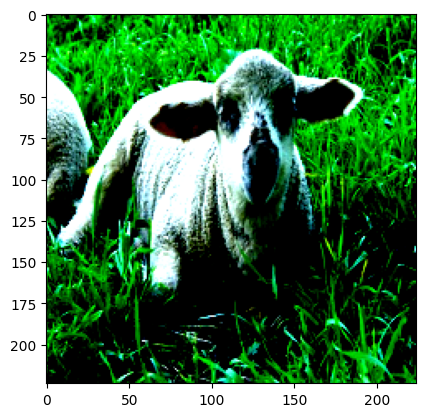

In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
plt.show()

In [31]:
x = image.unsqueeze(0).to(device)
y_pred = model(x)

In [39]:
for c in range(22):
  plt.title(f"Class {c} with size: {y_pred[0][c].size()}")
  plt.imshow(y_pred[0][c].cpu().detach().numpy())
  plt.show()

Output hidden; open in https://colab.research.google.com to view.